#  Применимость методов анализа

Автор: Никоноров Е.Н.
Дата: 21.11.2022
Курс: Аналитик данных (Data scientist) 2022
Кейс: №3 «Прогнозирование размеров сварного шва при электронно-лучевой сварке тонкостенных конструкций аэрокосмического назначения»

Искомые параметры: 
1.Width
2.Depth


Описание файла:
1. Загружаем данные из initail, merged, generated 
2. Формируем X, y 
3. Разделяем на обучающую и тестовую выборки
4. Линейная регрессия
5. Деревья
6. Сети
8. Выбор целевого метода

In [1]:
#импорт библиотек

import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
from sklearn import preprocessing
from sklearn.multioutput import MultiOutputRegressor

from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import recall_score

from sklearn.model_selection import GridSearchCV


from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error



from sklearn.preprocessing import scale
from sklearn import set_config 

In [2]:
#загрузка данных
df_merged = pd.read_excel("../Data/ds_merged.xlsx ")
df_merged = df_merged.drop(['Unnamed: 0'], axis =1)

df_initial = pd.read_excel("../Data/ds_initial.xlsx ")
df_initial = df_initial.drop(['Unnamed: 0'], axis =1)

df_initial_norm = pd.read_excel("../Data/ds_initial_norm.xlsx ")
df_initial_norm = df_initial_norm.drop(['Unnamed: 0'], axis =1)


df_generated = pd.read_excel("../Data/ds_generated.xlsx ")
df_generated = df_generated.drop(['Unnamed: 0'], axis =1)

 

In [3]:
#Входы и выходы для моделей
#менять датасет тут
df = df_initial

X=df.iloc[:,:4].to_numpy()
y=df.iloc[:,4:].to_numpy()

In [4]:
#Разделяем датасет на обучающую и тестовую выборки

X_train, X_test, y_train, y_test =  train_test_split(X, y , test_size=0.3, random_state=42)

In [5]:
#Итоговый датасет ошибок
errors_df = pd.DataFrame(columns=['target_var','model_name','MSE','R2'])

In [6]:
#Определение функции для визуализации
  
def save_result(y_train,y_train_pred, y_test, y_pred, model_name, ds):
    fig,axs = plt.subplots(figsize=(16,4), ncols=3)
    axs[0].scatter(y_train, y_train_pred)
    axs[0].set_title('train data')

    axs[1].scatter(y_pred, y_test, label="test data")
    axs[1].set_title('test data')
    err=y_pred - y_test
    axs[2].scatter(err[:,0], err[:,1], label="error")
    axs[2].set_title('error (test)')

    print('mse', mean_squared_error(y_test,y_pred))
    print('mae', mean_absolute_error(y_test,y_pred))
    print('Coef of determination (vec)', r2_score(y_test,y_pred))
    print('Coef of determination Depth', r2_score(y_test[:,0],y_pred[:,0]))
    print('Coef of determination Width', r2_score(y_test[:,1],y_pred[:,1]))
    
    
    plt.figure(figsize=(17,5))
    plt.title(f'Тестовые и прогнозные значения: {model_name}')
    plt.plot(y_test, label='Тест')
    plt.plot(y_pred, label='Прогноз')
    plt.legend(loc='best')
    plt.ylabel('W+D')
    plt.xlabel('Количество наблюдений')
    plt.show()
    
    
    MSE_depth = mean_squared_error(y_test[:,0], y_pred[:,0])
    R2_depth = r2_score(y_test[:,0],  y_pred[:,0])
    
    MSE_width = mean_squared_error(y_test[:,1], y_pred[:,1])
    R2_width = r2_score(y_test[:,1],  y_pred[:,1])

    linear_errors = pd.DataFrame({
        'model_name':model_name,
        'target_var':['Width', 'Depth'],
        'MSE':[MSE_width, MSE_depth],
        'R2':[R2_width, R2_depth]})
    ds = pd.concat([ds, linear_errors], ignore_index=True)
    return ds
    #reg.score(X_test, y_test)

    #((y_test-y_pred) ** 2).mean()

In [7]:
import numpy as np
from sklearn.linear_model import LinearRegression

# Линейная регрессия (вектор)

mse 0.01052184432854317
mae 0.07471079438024913
Coef of determination (vec) 0.8267746350900315
Coef of determination Depth 0.6976708789395949
Coef of determination Width 0.955878391240468


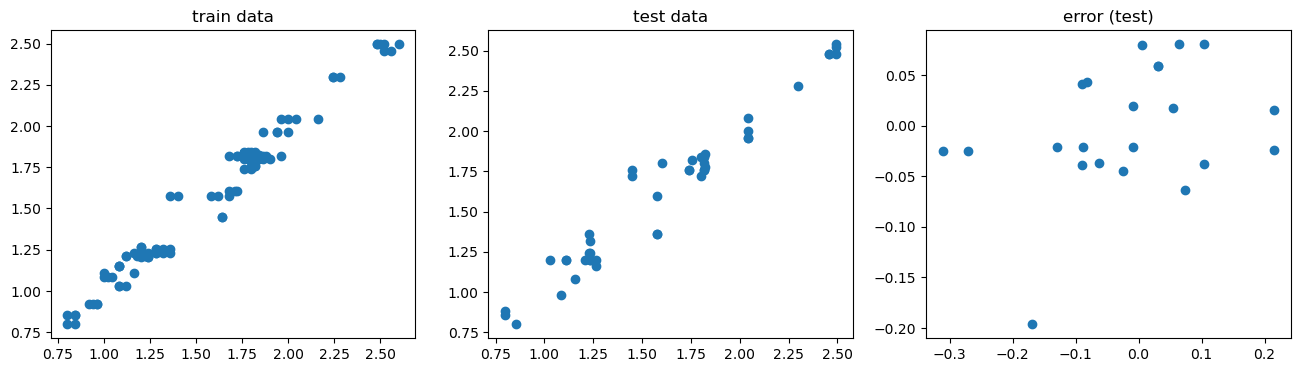

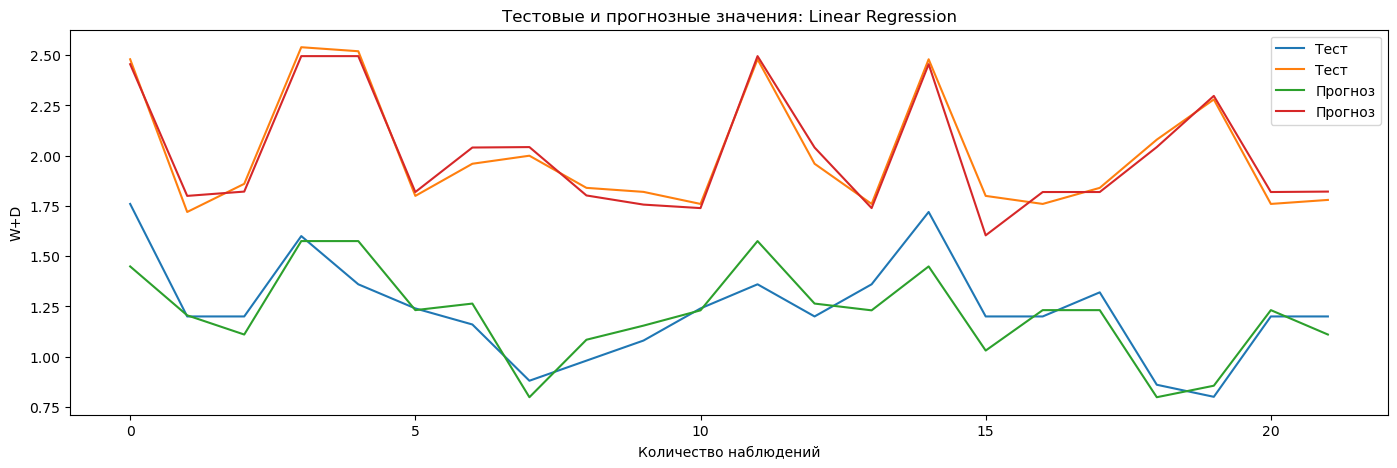

,target_var,model_name,MSE,R2
0,Width,Linear Regression,0.003766,0.955878
1,Depth,Linear Regression,0.017277,0.697671


In [8]:
reg = LinearRegression().fit(X_train, y_train)
y_train_pred = reg.predict(X_train)
y_pred = reg.predict(X_test)

errors_df = save_result(y_train,y_train_pred, y_test, y_pred, 'Linear Regression', errors_df)
errors_df

# Регрессия k-ближайших соседей

In [9]:
from sklearn.neighbors import KNeighborsRegressor

In [10]:
#Регрессия k-ближайших соседей
knr_model = KNeighborsRegressor()
neigh_params = {'n_neighbors' : range(1, 101, 1),
'weights' : ['uniform', 'distance'],
'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute']
}

GSCV_neigh = GridSearchCV(knr_model, neigh_params, n_jobs=-1, cv=10)
GSCV_neigh.fit(X_train, y_train)
neigh = GSCV_neigh.best_estimator_

C:\Users\Space\anaconda3\envs\tf\lib\site-packages\sklearn\model_selection\_search.py:972: UserWarning: One or more of the test scores are non-finite: [ 0.75460127  0.75460127  0.75651685  0.75448165  0.70220559  0.74531723
  0.6048982   0.73217055  0.4434058   0.73083017  0.31502075  0.73168213
  0.22372653  0.73069439  0.33611277  0.73069439  0.43995567  0.73069439
  0.47728958  0.73069439  0.47010023  0.73069439  0.38690236  0.73069439
  0.29357985  0.73069439  0.11152345  0.73069439 -0.10720962  0.73069439
 -0.33625717  0.73069439 -0.61800716  0.73069439 -0.90339454  0.73069439
 -1.07531082  0.73069439 -0.99687539  0.73069439 -0.94484989  0.73069439
 -0.90875066  0.73069439 -0.91176038  0.73069439 -0.92279361  0.73069439
 -0.94079675  0.73069439 -0.96180915  0.73069439 -0.92260252  0.73069439
 -0.86313173  0.73069439 -0.81511468  0.73069439 -0.75060428  0.73069439
 -0.69960592  0.73069439 -0.65097726  0.73069439 -0.62740426  0.73069439
 -0.60243564  0.73069439 -0.59623478  0.730694

mse 0.004540909090909091
mae 0.053636363636363635
Coef of determination (vec) 0.9268764775310774
Coef of determination Depth 0.8794180598137329
Coef of determination Width 0.974334895248422


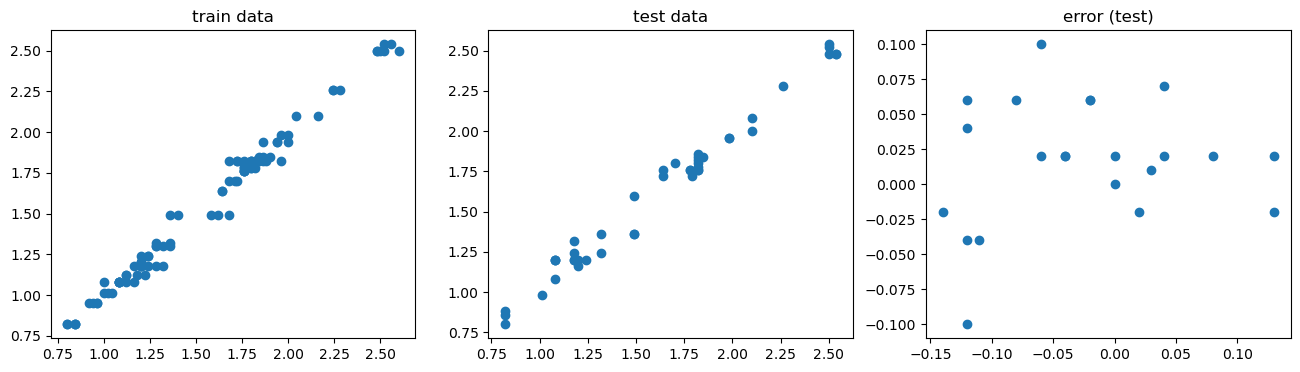

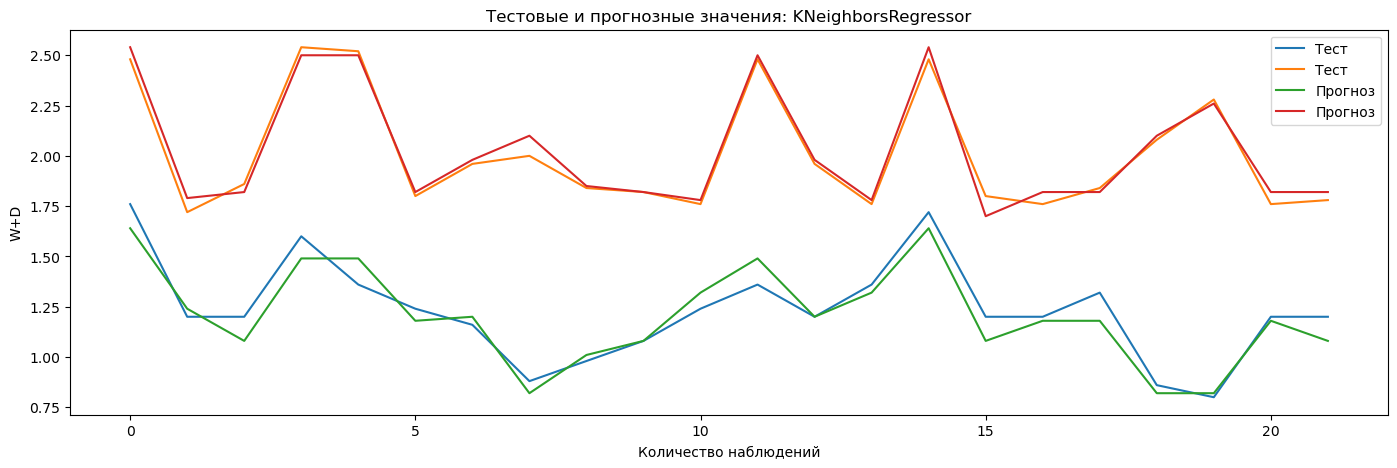

,target_var,model_name,MSE,R2
0,Width,Linear Regression,0.003766,0.955878
1,Depth,Linear Regression,0.017277,0.697671
2,Width,KNeighborsRegressor,0.002191,0.974335
3,Depth,KNeighborsRegressor,0.006891,0.879418


In [11]:
y_train_pred = neigh.predict(X_train)
y_pred = neigh.predict(X_test)

errors_df = save_result(y_train,y_train_pred, y_test, y_pred, 'KNeighborsRegressor', errors_df)
errors_df

# Случайный лес (вектор W+D)

In [12]:
import warnings
warnings.simplefilter("ignore")
#Случайный лес
rfr_model = RandomForestRegressor(random_state=14)
rfr_model_params = {
'n_estimators' : range(1, 100, 1),
'max_features': ['auto', 'sqrt', 'log2'],
'max_depth' : range(1, 5, 1),
'criterion':['mse']
} 

GSCV_rfr_model = GridSearchCV(rfr_model, rfr_model_params, cv=5, verbose=2)
GSCV_rfr_model.fit(X_train, y_train)
rfr_model = GSCV_rfr_model.best_estimator_
MSE = mean_squared_error(y_test, rfr_model.predict(X_test))
R2 = r2_score(y_test, rfr_model.predict(X_test))

Fitting 5 folds for each of 1188 candidates, totalling 5940 fits
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=1; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=1; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=1; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=1; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=1; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=2; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=2; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=2; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=2; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=2; total time=   0.0s
[CV] END criterion=mse, m

[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=21; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=21; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=22; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=22; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=22; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=22; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=22; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=23; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=23; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=23; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=23; total t

[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=41; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=41; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=42; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=42; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=42; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=42; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=42; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=43; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=43; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=43; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=43; total t

[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=60; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=60; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=61; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=61; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=61; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=61; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=61; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=62; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=62; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=62; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=62; total t

[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=79; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=79; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=79; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=80; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=80; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=80; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=80; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=80; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=81; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=81; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=81; total t

[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=98; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=98; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=98; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=98; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=98; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=99; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=99; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=99; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=99; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=99; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=1; total ti

[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=18; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=18; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=18; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=18; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=19; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=19; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=19; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=19; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=19; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=20; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=20; total t

[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=37; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=37; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=37; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=38; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=38; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=38; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=38; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=38; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=39; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=39; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=39; total t

[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=56; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=56; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=56; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=56; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=56; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=57; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=57; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=57; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=57; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=57; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=58; total t

[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=74; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=74; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=74; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=75; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=75; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=75; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=75; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=75; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=76; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=76; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=76; total t

[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=92; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=92; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=93; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=93; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=93; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=93; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=93; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=94; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=94; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=94; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=94; total t

[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=16; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=17; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=17; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=17; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=17; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=17; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=18; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=18; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=18; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=18; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=18; total t

[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=37; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=37; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=37; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=37; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=37; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=38; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=38; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=38; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=38; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=38; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=39; total t

[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=55; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=55; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=56; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=56; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=56; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=56; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=56; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=57; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=57; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=57; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=57; total t

[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=74; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=74; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=74; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=74; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=74; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=75; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=75; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=75; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=75; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=75; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=76; total t

[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=92; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=92; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=92; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=93; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=93; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=93; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=93; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=93; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=94; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=94; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=94; total t

[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=11; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=11; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=12; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=12; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=12; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=12; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=12; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=13; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=13; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=13; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=13; total t

[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=31; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=31; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=31; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=32; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=32; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=32; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=32; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=32; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=33; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=33; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=33; total t

[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=49; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=49; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=49; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=50; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=50; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=50; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=50; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=50; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=51; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=51; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=51; total t

[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=68; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=68; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=68; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=68; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=68; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=69; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=69; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=69; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=69; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=69; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=70; total t

[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=86; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=86; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=86; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=87; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=87; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=87; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=87; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=87; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=88; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=88; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=88; total t

[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=12; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=12; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=12; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=12; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=13; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=13; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=13; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=13; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=13; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=14; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=14; total t

[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=31; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=32; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=32; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=32; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=32; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=32; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=33; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=33; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=33; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=33; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=33; total t

[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=50; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=50; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=50; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=50; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=50; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=51; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=51; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=51; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=51; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=51; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=52; total t

[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=68; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=68; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=68; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=68; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=69; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=69; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=69; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=69; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=69; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=70; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=70; total t

[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=86; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=86; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=86; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=86; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=87; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=87; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=87; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=87; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=87; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=88; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=88; total t

[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=7; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=7; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=7; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=7; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=7; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=8; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=8; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=8; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=8; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=8; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=9; total time=   0.0s

[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=26; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=26; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=27; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=27; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=27; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=27; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=27; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=28; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=28; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=28; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=28; total t

[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=46; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=46; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=46; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=47; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=47; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=47; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=47; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=47; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=48; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=48; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=48; total t

[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=65; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=66; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=66; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=66; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=66; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=66; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=67; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=67; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=67; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=67; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=67; total t

[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=84; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=85; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=85; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=85; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=85; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=85; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=86; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=86; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=86; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=86; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=86; total t

[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=12; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=12; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=13; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=13; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=13; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=13; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=13; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=14; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=14; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=14; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=14; total t

[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=32; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=32; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=32; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=32; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=32; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=33; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=33; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=33; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=33; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=33; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=34; total t

[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=50; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=50; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=50; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=50; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=50; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=51; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=51; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=51; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=51; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=51; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=52; total t

[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=68; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=68; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=68; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=69; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=69; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=69; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=69; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=69; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=70; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=70; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=70; total t

[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=87; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=87; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=87; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=87; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=88; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=88; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=88; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=88; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=88; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=89; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=89; total t

[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=7; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=7; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=7; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=7; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=7; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=8; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=8; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=8; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=8; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=8; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=9; total time=   0.0s

[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=26; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=26; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=26; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=27; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=27; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=27; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=27; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=27; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=28; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=28; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=28; total t

[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=45; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=45; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=46; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=46; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=46; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=46; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=46; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=47; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=47; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=47; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=47; total t

[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=64; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=64; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=64; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=65; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=65; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=65; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=65; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=65; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=66; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=66; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=66; total t

[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=82; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=83; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=83; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=83; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=83; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=83; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=84; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=84; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=84; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=84; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=84; total t

[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=6; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=6; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=7; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=7; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=7; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=7; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=7; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=8; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=8; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=8; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=8; total time=   0.0s

[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=26; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=26; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=26; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=27; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=27; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=27; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=27; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=27; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=28; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=28; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=28; total t

[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=44; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=44; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=44; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=45; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=45; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=45; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=45; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=45; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=46; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=46; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=46; total t

[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=62; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=62; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=62; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=63; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=63; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=63; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=63; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=63; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=64; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=64; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=64; total t

[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=81; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=81; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=81; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=81; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=81; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=82; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=82; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=82; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=82; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=82; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=83; total t

[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=99; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=1; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=1; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=1; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=1; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=1; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=2; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=2; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=2; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=2; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=2; total time=   0.0

[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=21; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=21; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=22; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=22; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=22; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=22; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=22; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=23; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=23; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=23; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=23; total t

[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=41; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=41; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=42; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=42; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=42; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=42; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=42; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=43; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=43; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=43; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=43; total t

[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=61; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=61; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=61; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=61; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=61; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=62; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=62; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=62; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=62; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=62; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=63; total t

[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=79; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=79; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=79; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=79; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=80; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=80; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=80; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=80; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=80; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=81; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=81; total t

[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=97; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=98; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=98; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=98; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=98; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=98; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=99; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=99; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=99; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=99; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=99; total t

[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=17; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=17; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=17; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=18; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=18; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=18; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=18; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=18; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=19; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=19; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=19; total t

[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=36; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=36; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=37; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=37; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=37; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=37; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=37; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=38; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=38; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=38; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=38; total t

[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=55; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=55; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=55; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=55; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=55; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=56; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=56; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=56; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=56; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=56; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=57; total t

[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=73; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=73; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=73; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=73; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=74; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=74; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=74; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=74; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=74; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=75; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=75; total t

[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=91; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=91; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=91; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=91; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=92; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=92; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=92; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=92; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=92; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=93; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=93; total t

[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=14; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=14; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=14; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=14; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=15; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=15; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=15; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=15; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=15; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=16; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=16; total t

[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=32; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=32; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=33; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=33; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=33; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=33; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=33; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=34; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=34; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=34; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=34; total t

[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=50; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=50; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=51; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=51; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=51; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=51; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=51; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=52; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=52; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=52; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=52; total t

[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=69; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=69; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=69; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=70; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=70; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=70; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=70; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=70; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=71; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=71; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=71; total t

[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=88; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=88; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=88; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=88; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=89; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=89; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=89; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=89; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=89; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=90; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=90; total t

mse 0.004626672418809707
mae 0.05285988290514576
Coef of determination (vec) 0.9237746061721015
Coef of determination Depth 0.8667291616382651
Coef of determination Width 0.980820050705938


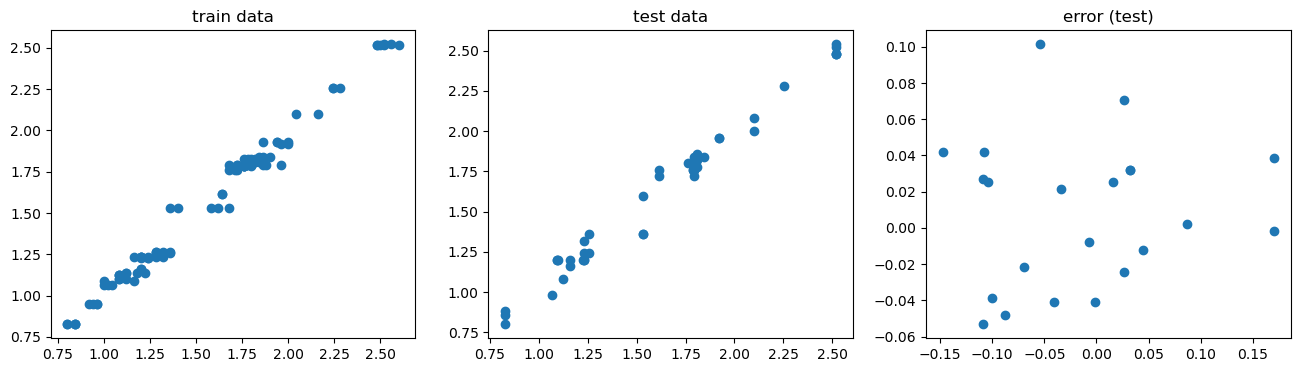

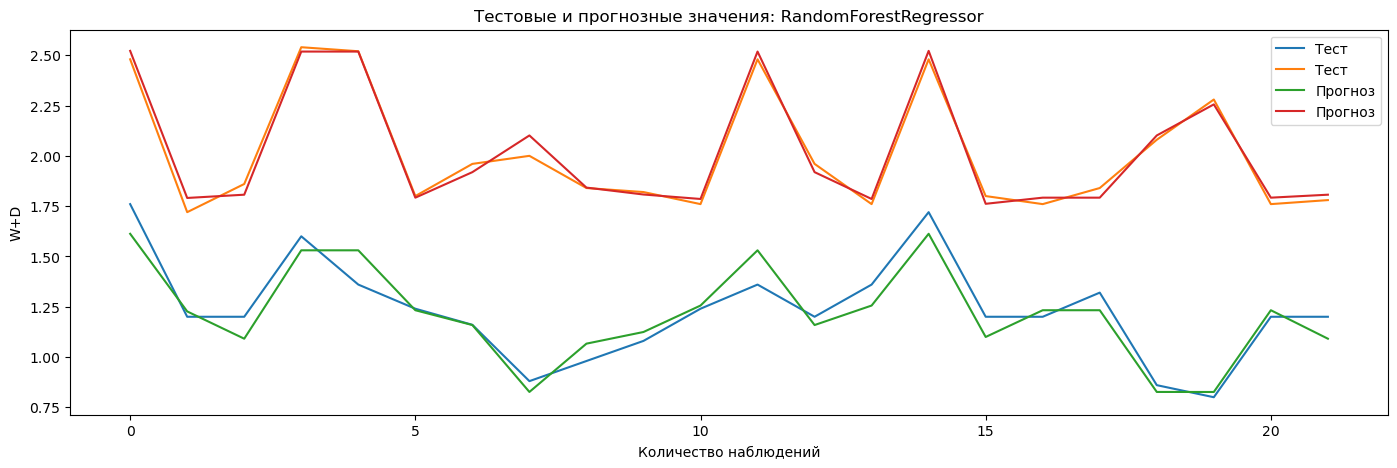

,target_var,model_name,MSE,R2
0,Width,Linear Regression,0.003766,0.955878
1,Depth,Linear Regression,0.017277,0.697671
2,Width,KNeighborsRegressor,0.002191,0.974335
3,Depth,KNeighborsRegressor,0.006891,0.879418
4,Width,RandomForestRegressor,0.001637,0.980820
5,Depth,RandomForestRegressor,0.007616,0.866729


In [13]:


y_train_pred = rfr_model.predict(X_train)
y_pred = rfr_model.predict(X_test)

errors_df = save_result(y_train,y_train_pred, y_test, y_pred, 'RandomForestRegressor', errors_df)
errors_df

# Многослойный перцептрон(vector W+D)

In [14]:
from sklearn.neural_network import MLPRegressor

In [15]:
from sklearn.neural_network import MLPRegressor
print('Multi-layer Perceptron')

mlpr_model = MLPRegressor(random_state=14)

mlpr_model_params = {
'hidden_layer_sizes' : [(100, 100, 50, 25, 12), (144, 144, 72, 36,
12, 1), (12, 12, 12, 12, 12),
(144, 144, 144, 72, 72, 36, 36), ()],
'activation' : ['identity', 'logistic', 'tanh', 'relu'],
'solver' : ['sgd', 'adam'],
'max_iter' : [1000],
'learning_rate' : ['constant', 'adaptive', 'invscaling']
}

GSCV_mlpr_model = GridSearchCV(mlpr_model, mlpr_model_params, n_jobs=-1, cv=10)
GSCV_mlpr_model.fit(X_train, y_train)
mlp = GSCV_mlpr_model.best_estimator_

reg = mlp.fit(X_train, y_train)


Multi-layer Perceptron


mse 0.007175226879840484
mae 0.06761437911168516
Coef of determination (vec) 0.8840042247163575
Coef of determination Depth 0.8067355262423264
Coef of determination Width 0.9612729231903888


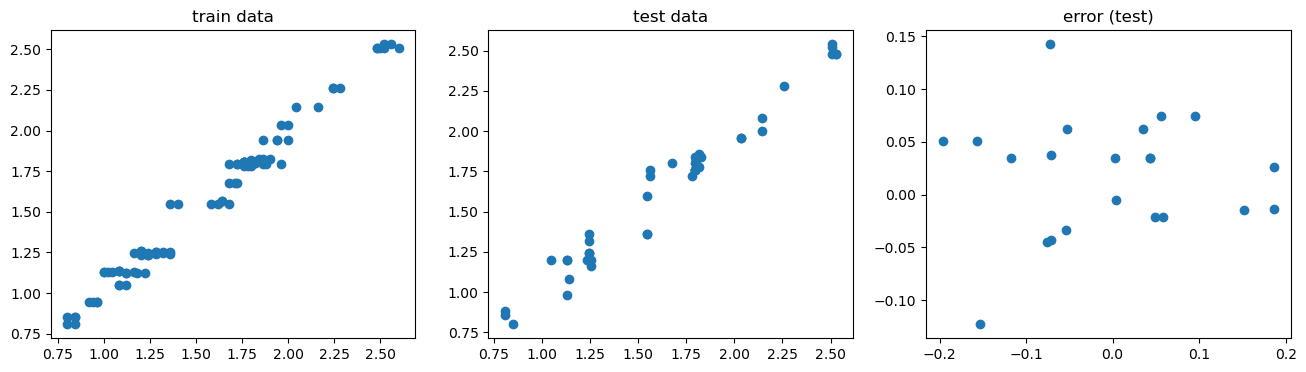

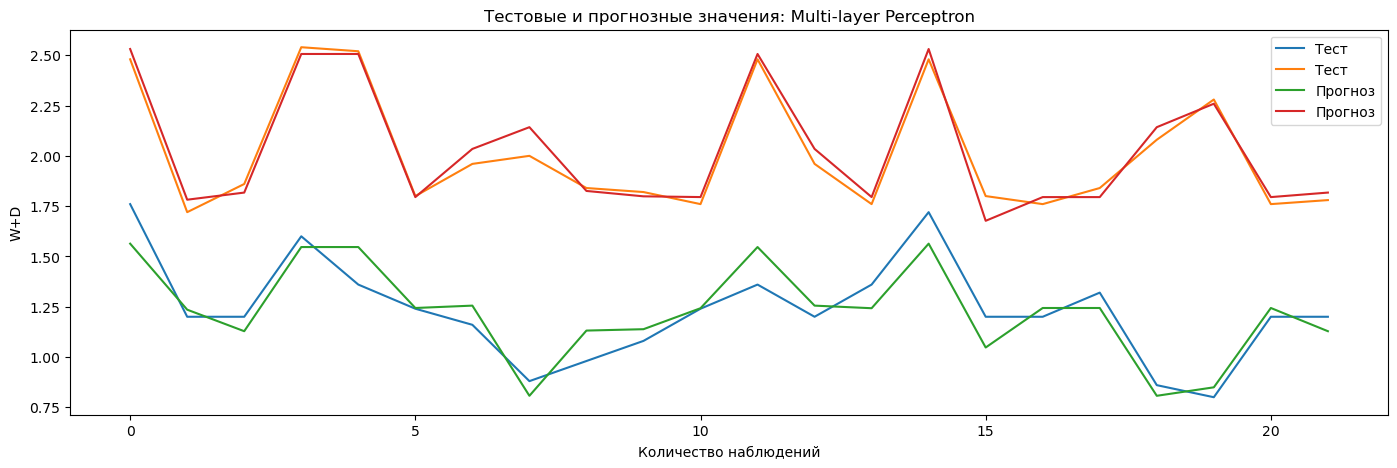

,target_var,model_name,MSE,R2
0,Width,Linear Regression,0.003766,0.955878
1,Depth,Linear Regression,0.017277,0.697671
2,Width,KNeighborsRegressor,0.002191,0.974335
3,Depth,KNeighborsRegressor,0.006891,0.879418
4,Width,RandomForestRegressor,0.001637,0.980820
5,Depth,RandomForestRegressor,0.007616,0.866729
6,Width,Multi-layer Perceptron,0.003306,0.961273
7,Depth,Multi-layer Perceptron,0.011045,0.806736


In [16]:

y_train_pred = reg.predict(X_train)
y_pred = reg.predict(X_test)

errors_df = save_result(y_train,y_train_pred, y_test, y_pred, 'Multi-layer Perceptron', errors_df)
errors_df


In [17]:
GSCV_mlpr_model.best_params_

{'activation': 'tanh',
 'hidden_layer_sizes': (144, 144, 144, 72, 72, 36, 36),
 'learning_rate': 'constant',
 'max_iter': 1000,
 'solver': 'adam'}

# Лассо регрессия

In [18]:
from sklearn.linear_model import Lasso

In [19]:
lasso_model = Lasso(random_state=14)
lasso_model_params = {
'alpha': np.linspace(0, 1, 100)
} 

GSCV_lasso_model = GridSearchCV(lasso_model, lasso_model_params, cv=10, verbose=2)
GSCV_lasso_model.fit(X_train, y_train)
lasso_model = GSCV_lasso_model.best_estimator_


Fitting 10 folds for each of 100 candidates, totalling 1000 fits
[CV] END ..........................................alpha=0.0; total time=   0.0s
[CV] END ..........................................alpha=0.0; total time=   0.0s
[CV] END ..........................................alpha=0.0; total time=   0.0s
[CV] END ..........................................alpha=0.0; total time=   0.0s
[CV] END ..........................................alpha=0.0; total time=   0.0s
[CV] END ..........................................alpha=0.0; total time=   0.0s
[CV] END ..........................................alpha=0.0; total time=   0.0s
[CV] END ..........................................alpha=0.0; total time=   0.0s
[CV] END ..........................................alpha=0.0; total time=   0.0s
[CV] END ..........................................alpha=0.0; total time=   0.0s
[CV] END .........................alpha=0.010101010101010102; total time=   0.0s
[CV] END .........................alpha=0.01

[CV] END ..........................alpha=0.20202020202020204; total time=   0.0s
[CV] END ..........................alpha=0.20202020202020204; total time=   0.0s
[CV] END ..........................alpha=0.20202020202020204; total time=   0.0s
[CV] END ..........................alpha=0.20202020202020204; total time=   0.0s
[CV] END ..........................alpha=0.20202020202020204; total time=   0.0s
[CV] END ..........................alpha=0.20202020202020204; total time=   0.0s
[CV] END ..........................alpha=0.20202020202020204; total time=   0.0s
[CV] END ..........................alpha=0.20202020202020204; total time=   0.0s
[CV] END ..........................alpha=0.20202020202020204; total time=   0.0s
[CV] END ..........................alpha=0.20202020202020204; total time=   0.0s
[CV] END ..........................alpha=0.21212121212121213; total time=   0.0s
[CV] END ..........................alpha=0.21212121212121213; total time=   0.0s
[CV] END ...................

[CV] END ...........................alpha=0.4444444444444445; total time=   0.0s
[CV] END ...........................alpha=0.4444444444444445; total time=   0.0s
[CV] END ...........................alpha=0.4444444444444445; total time=   0.0s
[CV] END ...........................alpha=0.4545454545454546; total time=   0.0s
[CV] END ...........................alpha=0.4545454545454546; total time=   0.0s
[CV] END ...........................alpha=0.4545454545454546; total time=   0.0s
[CV] END ...........................alpha=0.4545454545454546; total time=   0.0s
[CV] END ...........................alpha=0.4545454545454546; total time=   0.0s
[CV] END ...........................alpha=0.4545454545454546; total time=   0.0s
[CV] END ...........................alpha=0.4545454545454546; total time=   0.0s
[CV] END ...........................alpha=0.4545454545454546; total time=   0.0s
[CV] END ...........................alpha=0.4545454545454546; total time=   0.0s
[CV] END ...................

[CV] END ...........................alpha=0.7171717171717172; total time=   0.0s
[CV] END ...........................alpha=0.7171717171717172; total time=   0.0s
[CV] END ...........................alpha=0.7171717171717172; total time=   0.0s
[CV] END ...........................alpha=0.7171717171717172; total time=   0.0s
[CV] END ...........................alpha=0.7171717171717172; total time=   0.0s
[CV] END ...........................alpha=0.7171717171717172; total time=   0.0s
[CV] END ...........................alpha=0.7171717171717172; total time=   0.0s
[CV] END ...........................alpha=0.7171717171717172; total time=   0.0s
[CV] END ...........................alpha=0.7272727272727273; total time=   0.0s
[CV] END ...........................alpha=0.7272727272727273; total time=   0.0s
[CV] END ...........................alpha=0.7272727272727273; total time=   0.0s
[CV] END ...........................alpha=0.7272727272727273; total time=   0.0s
[CV] END ...................

[CV] END .............................alpha=0.98989898989899; total time=   0.0s
[CV] END .............................alpha=0.98989898989899; total time=   0.0s
[CV] END .............................alpha=0.98989898989899; total time=   0.0s
[CV] END .............................alpha=0.98989898989899; total time=   0.0s
[CV] END .............................alpha=0.98989898989899; total time=   0.0s
[CV] END .............................alpha=0.98989898989899; total time=   0.0s
[CV] END .............................alpha=0.98989898989899; total time=   0.0s
[CV] END .............................alpha=0.98989898989899; total time=   0.0s
[CV] END .............................alpha=0.98989898989899; total time=   0.0s
[CV] END ..........................................alpha=1.0; total time=   0.0s
[CV] END ..........................................alpha=1.0; total time=   0.0s
[CV] END ..........................................alpha=1.0; total time=   0.0s
[CV] END ...................

mse 0.010521844328541894
mae 0.0747107943802418
Coef of determination (vec) 0.8267746350900742
Coef of determination Depth 0.6976708789397632
Coef of determination Width 0.9558783912403852


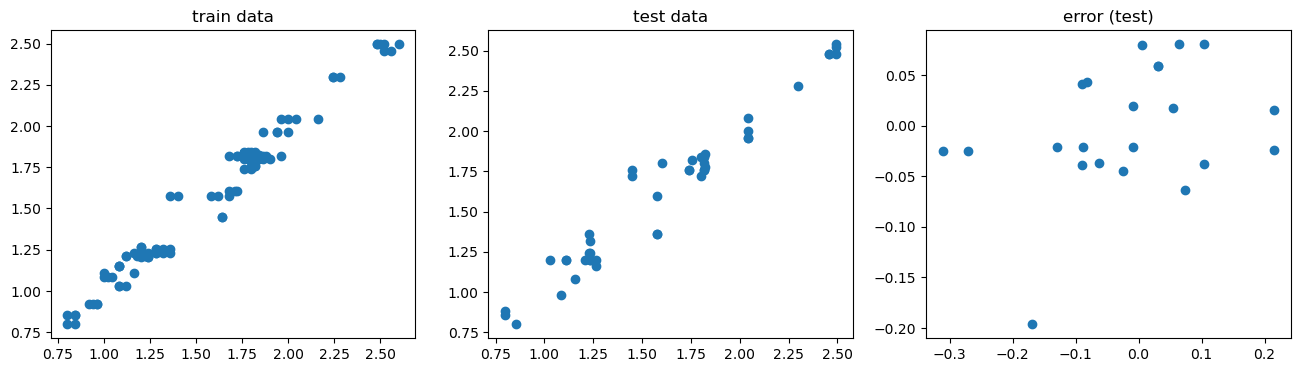

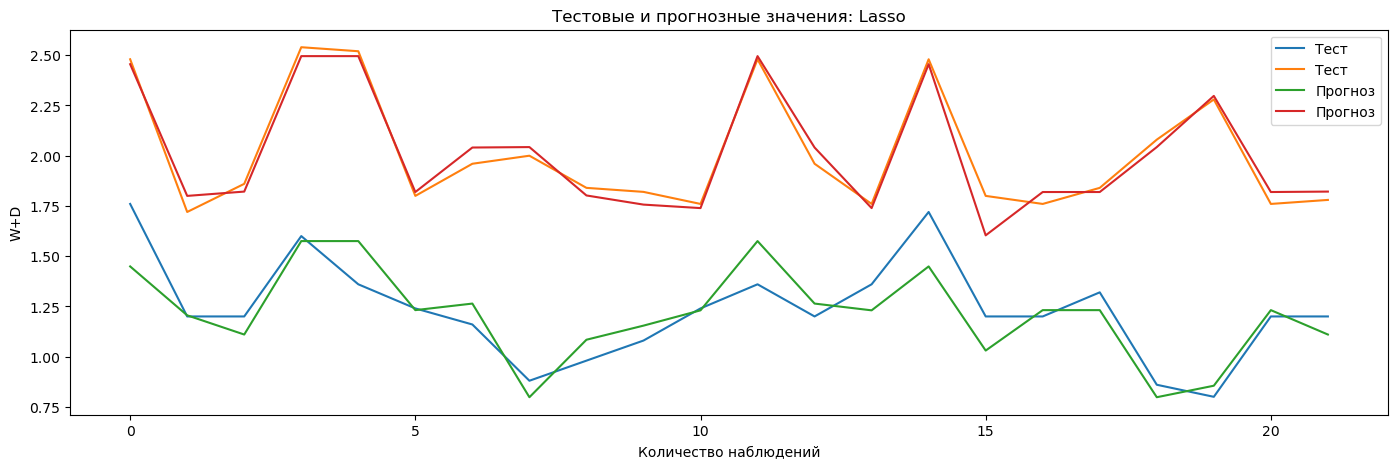

,target_var,model_name,MSE,R2
0,Width,Linear Regression,0.003766,0.955878
1,Depth,Linear Regression,0.017277,0.697671
2,Width,KNeighborsRegressor,0.002191,0.974335
3,Depth,KNeighborsRegressor,0.006891,0.879418
4,Width,RandomForestRegressor,0.001637,0.980820
5,Depth,RandomForestRegressor,0.007616,0.866729
6,Width,Multi-layer Perceptron,0.003306,0.961273
7,Depth,Multi-layer Perceptron,0.011045,0.806736
8,Width,Lasso,0.003766,0.955878
9,Depth,Lasso,0.017277,0.697671


In [20]:
y_train_pred = lasso_model.predict(X_train)
y_pred = lasso_model.predict(X_test)

errors_df = save_result(y_train,y_train_pred, y_test, y_pred, 'Lasso', errors_df)
errors_df

# Нейростеть tensorflow

In [21]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers

In [22]:
#Нормализация
x_train_norm = tf.keras.layers.Normalization(axis=-1)
x_train_norm.adapt(np.array(X_train))

In [23]:

#Cлои и конфиг нейросети
model = tf.keras.Sequential([x_train_norm,
                        layers.Dense(144,activation='tanh'),
                        layers.Dense(144, activation='tanh'),
                        layers.Dense(144, activation='tanh'),
                        layers.Dense(72,activation='tanh'),
                        layers.Dense(72,activation='tanh'),
                        layers.Dense(36,activation='tanh'),
                        layers.Dense(36,activation='tanh'),
                        layers.Dense(2)])
model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss='mean_squared_error')
model.summary()
model_hist = model.fit(X_train, y_train, epochs=100, verbose=1, validation_split = 0.2)



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 4)                9         
 n)                                                              
                                                                 
 dense (Dense)               (None, 144)               720       
                                                                 
 dense_1 (Dense)             (None, 144)               20880     
                                                                 
 dense_2 (Dense)             (None, 144)               20880     
                                                                 
 dense_3 (Dense)             (None, 72)                10440     
                                                                 
 dense_4 (Dense)             (None, 72)                5256      
                                                        

Epoch 67/100
2/2 [==============================] - 0s 17ms/step - loss: 0.0043 - val_loss: 0.0591
Epoch 68/100
2/2 [==============================] - 0s 17ms/step - loss: 0.0044 - val_loss: 0.0554
Epoch 69/100
2/2 [==============================] - 0s 18ms/step - loss: 0.0043 - val_loss: 0.0538
Epoch 70/100
2/2 [==============================] - 0s 18ms/step - loss: 0.0042 - val_loss: 0.0531
Epoch 71/100
2/2 [==============================] - 0s 18ms/step - loss: 0.0041 - val_loss: 0.0537
Epoch 72/100
2/2 [==============================] - 0s 18ms/step - loss: 0.0041 - val_loss: 0.0557
Epoch 73/100
2/2 [==============================] - 0s 18ms/step - loss: 0.0040 - val_loss: 0.0578
Epoch 74/100
2/2 [==============================] - 0s 18ms/step - loss: 0.0041 - val_loss: 0.0583
Epoch 75/100
2/2 [==============================] - 0s 18ms/step - loss: 0.0042 - val_loss: 0.0558
Epoch 76/100
2/2 [==============================] - 0s 18ms/step - loss: 0.0040 - val_loss: 0.0529
Epoch 77/1

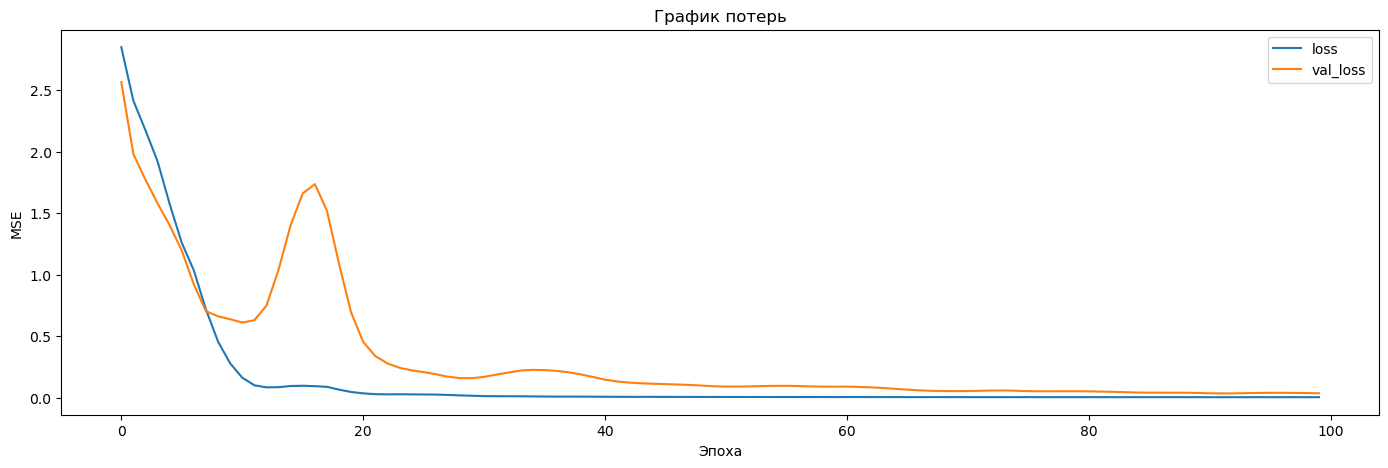

In [24]:
#Визуализация потерь на тренировочной и тестовой модели
def model_loss_plot(model_hist):
    plt.figure(figsize=(17,5))
    plt.plot(model_hist.history['loss'])
    plt.plot(model_hist.history['val_loss'])
    plt.title('График потерь')
    plt.ylabel('MSE')
    plt.xlabel('Эпоха')
    plt.legend(['loss', 'val_loss'], loc='best')
    plt.show()
model_loss_plot(model_hist)

1/1 [==============================] - 0s 14ms/step
mse 0.013112095767467446
mae 0.07505656052719462
Coef of determination (vec) 0.807649612466093
Coef of determination Depth 0.7655447311084398
Coef of determination Width 0.8497544938237461


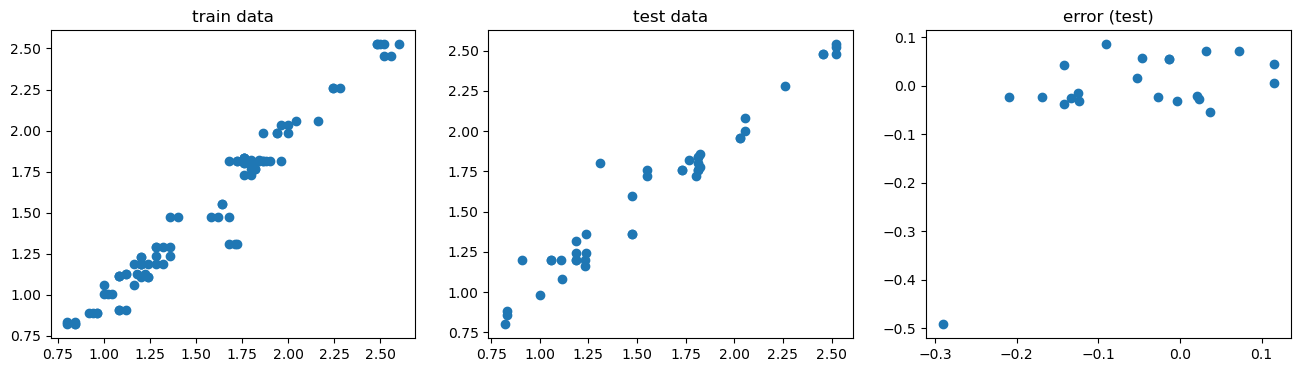

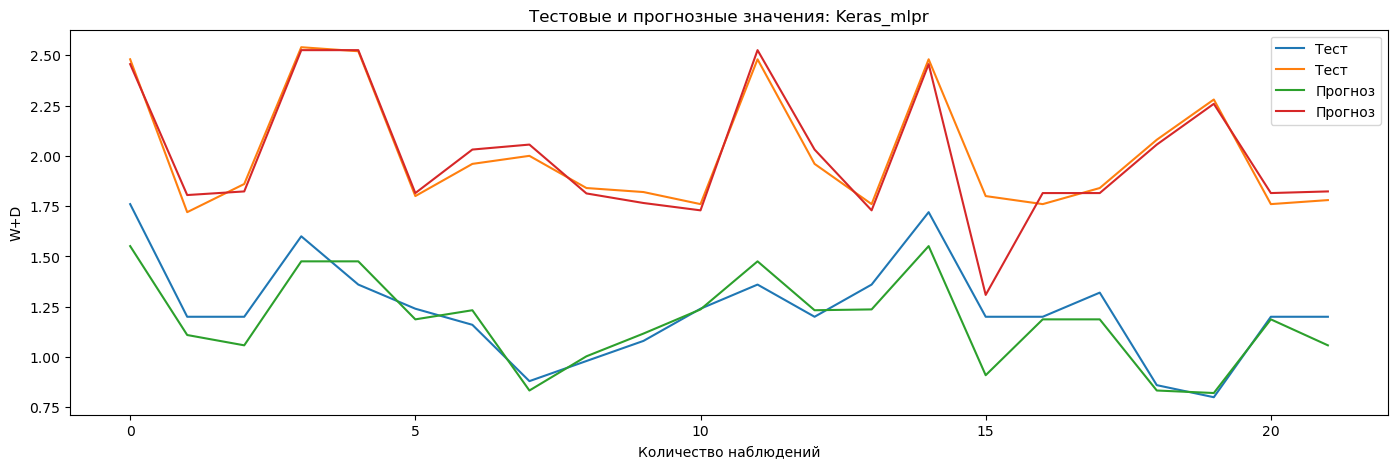

,target_var,model_name,MSE,R2
0,Width,Linear Regression,0.003766,0.955878
1,Depth,Linear Regression,0.017277,0.697671
2,Width,KNeighborsRegressor,0.002191,0.974335
3,Depth,KNeighborsRegressor,0.006891,0.879418
4,Width,RandomForestRegressor,0.001637,0.980820
5,Depth,RandomForestRegressor,0.007616,0.866729
6,Width,Multi-layer Perceptron,0.003306,0.961273
7,Depth,Multi-layer Perceptron,0.011045,0.806736
8,Width,Lasso,0.003766,0.955878
9,Depth,Lasso,0.017277,0.697671


In [25]:
#Визуализация

y_train_pred = model.predict(X_train)
y_pred = model.predict(X_test)

errors_df = save_result(y_train,y_train_pred, y_test, y_pred, 'Keras_mlpr', errors_df)
errors_df

# Support Vector Regression

In [26]:
from sklearn.svm import SVR

svr_rbf = SVR(kernel="rbf", C=1, gamma=1, epsilon=0.04, max_iter=1000)

print('rbf')
multiSvr = MultiOutputRegressor(svr_rbf)
rbf = multiSvr.fit(X_train, y_train)

rbf


mse 0.004492944784884458
mae 0.05210364348423596
Coef of determination (vec) 0.9269474724865643
Coef of determination Depth 0.8764480739100513
Coef of determination Width 0.9774468710630773


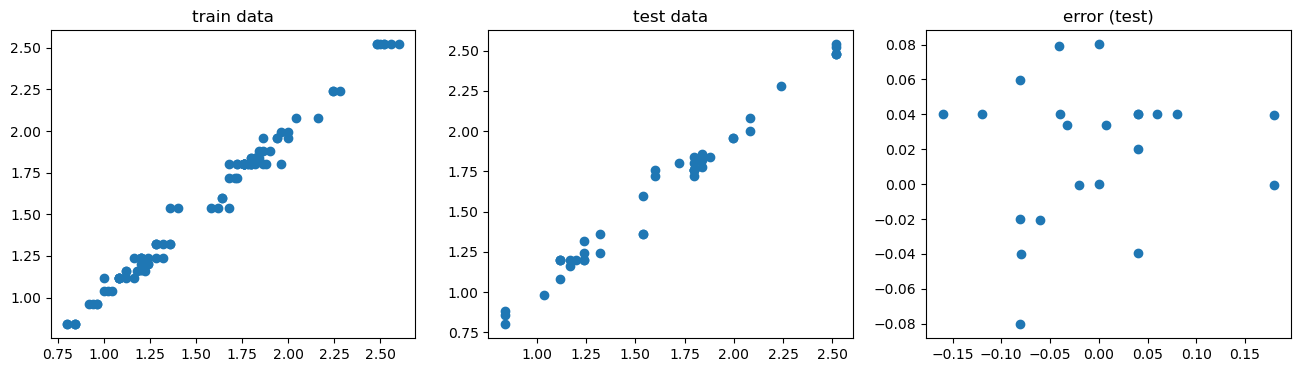

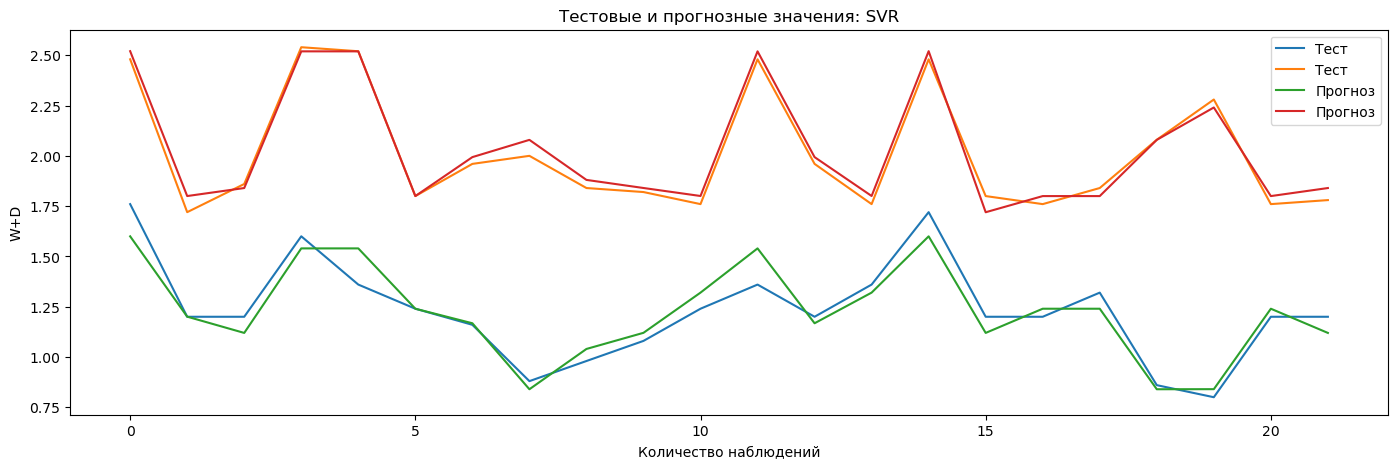

,target_var,model_name,MSE,R2
0,Width,Linear Regression,0.003766,0.955878
1,Depth,Linear Regression,0.017277,0.697671
2,Width,KNeighborsRegressor,0.002191,0.974335
3,Depth,KNeighborsRegressor,0.006891,0.879418
4,Width,RandomForestRegressor,0.001637,0.980820
5,Depth,RandomForestRegressor,0.007616,0.866729
6,Width,Multi-layer Perceptron,0.003306,0.961273
7,Depth,Multi-layer Perceptron,0.011045,0.806736
8,Width,Lasso,0.003766,0.955878
9,Depth,Lasso,0.017277,0.697671


In [27]:
y_train_pred = rbf.predict(X_train)
y_pred = rbf.predict(X_test)

errors_df = save_result(y_train,y_train_pred, y_test, y_pred, 'SVR', errors_df)
errors_df

# Дерево решений

In [28]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor


print('Dtree')
multi = MultiOutputRegressor(DecisionTreeRegressor(random_state=42, max_depth=20))
reg = multi.fit(X_train, y_train)


Dtree


mse 0.004414911616161616
mae 0.05156060606060606
Coef of determination (vec) 0.9284402744346074
Coef of determination Depth 0.879949383930121
Coef of determination Width 0.9769311649390939


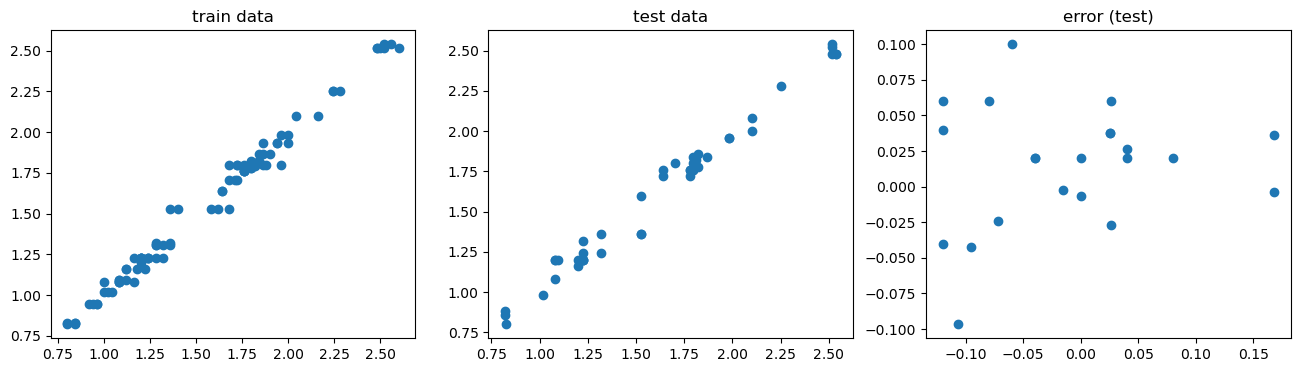

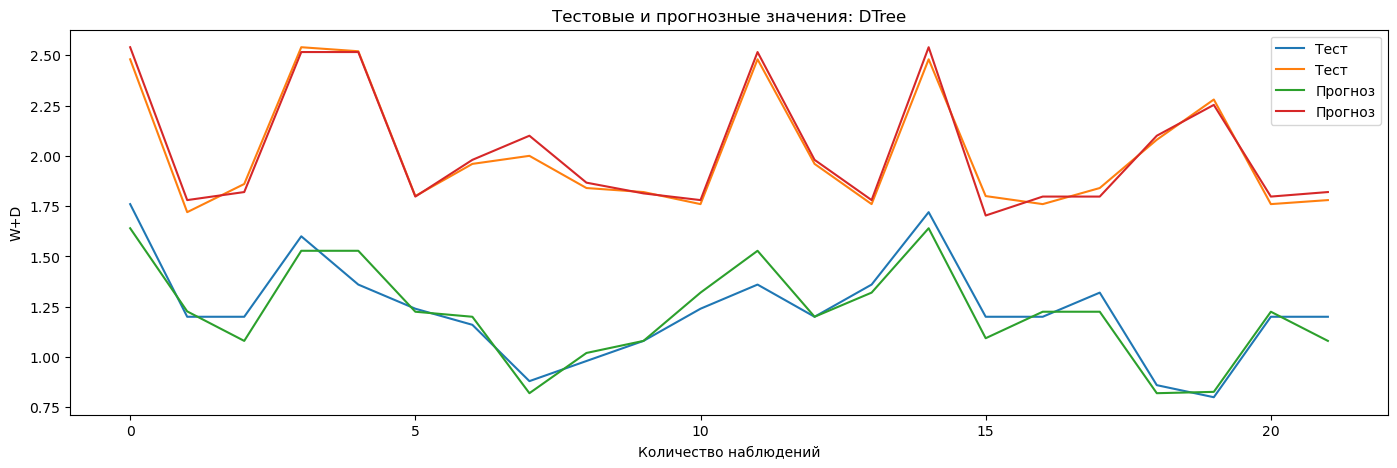

,target_var,model_name,MSE,R2
0,Width,Linear Regression,0.003766,0.955878
1,Depth,Linear Regression,0.017277,0.697671
2,Width,KNeighborsRegressor,0.002191,0.974335
3,Depth,KNeighborsRegressor,0.006891,0.879418
4,Width,RandomForestRegressor,0.001637,0.980820
5,Depth,RandomForestRegressor,0.007616,0.866729
6,Width,Multi-layer Perceptron,0.003306,0.961273
7,Depth,Multi-layer Perceptron,0.011045,0.806736
8,Width,Lasso,0.003766,0.955878
9,Depth,Lasso,0.017277,0.697671


In [29]:
y_train_pred = multi.predict(X_train)
y_pred = multi.predict(X_test)

errors_df = save_result(y_train,y_train_pred, y_test, y_pred, 'DTree', errors_df)
errors_df

# Выводы:

In [30]:
#лучший результат показал RandomForest, DTree, KNeighborsRegressor, SVR
# Методы дают +- одинаковый результат
#необходимо доп исследование 
#выбираем  KNeighborsRegressor